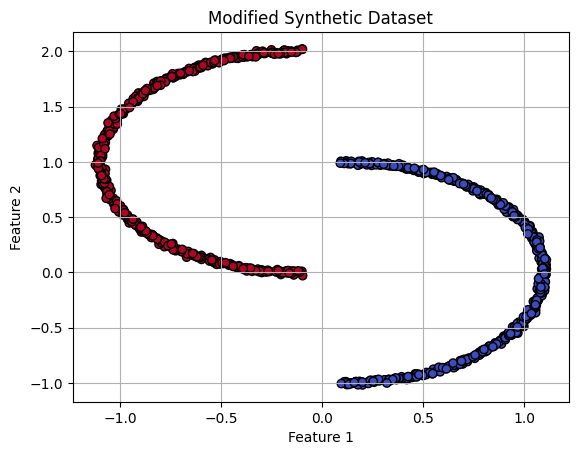

In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate the dataset
X, y = make_moons(n_samples=1000, noise=0.01, random_state=42)

# Swap x and y
X[:, 0], X[:, 1] = X[:, 1], X[:, 0].copy()

# Shift the data to place class 0 on x>0 and class 1 on x<0
X[:, 0] = X[:, 0] - np.mean(X[:, 0])  # Center the data around x=0
X[y == 0, 0] += 0.35  # Shift class 0 to the right
X[y == 1, 0] -= 0.35  # Shift class 1 to the left

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k')
plt.title('Modified Synthetic Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Train Data')

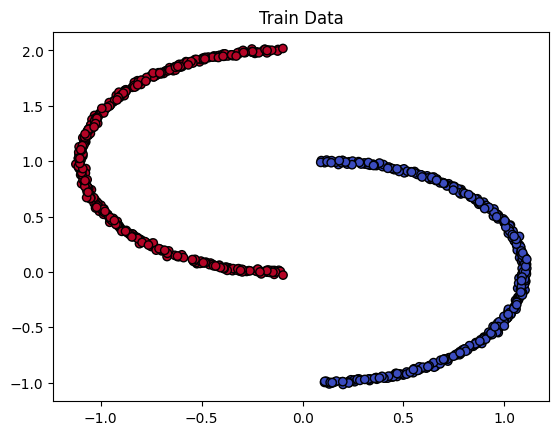

In [2]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# plot the train and test data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor='k')
plt.title('Train Data')

In [3]:
X_train.shape, y_train.shape, np.unique(y_train)

((800, 2), (800,), array([0, 1]))

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assume X_train and y_train are already defined (e.g., as NumPy arrays)
# Normalize and create a DataLoader
X_train_tensor = torch.tensor(X_train).float()
data_mean = X_train.mean().item()
data_std = X_train.std().item()
print(f"{data_mean=:.3f}, {data_std=:.3f}")

X_train_tensor = (X_train_tensor - data_mean) / data_std
y_train_tensor = torch.tensor(y_train).long()
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# -----------------------------
# Noise scheduler parameters for training
# -----------------------------
sigma_min_train = 0.02
sigma_max_train = 88.0
rho = 7.0

def sample_sigma(batch_size, sigma_min, sigma_max, rho):
    """
    Sample noise levels sigma using the noise scheduler:
      sigma = (sigma_min^(1/rho) + u*(sigma_max^(1/rho) - sigma_min^(1/rho)))^rho,
    where u ~ Uniform(0, 1).
    """
    u = np.random.uniform(0, 1, batch_size)
    u = torch.from_numpy(u).float().unsqueeze(-1)
    sigma = ((sigma_min ** (1.0 / rho)) +
             u * ((sigma_max ** (1.0 / rho)) - (sigma_min ** (1.0 / rho)))) ** rho
    return sigma  # shape: [batch_size, 1]

# -----------------------------
# New model architecture with sigma injection in every linear layer
# -----------------------------
class MLPBlock(nn.Module):
    """
    A single residual block where every linear transformation is conditioned on sigma.
    
    The block consists of three sub-steps:
      1) Transform x from n_feat -> 4*n_feat, while adding a sigma contribution.
      2) Process through another 4*n_feat -> 4*n_feat layer (with sigma).
      3) Project back to n_feat (again with sigma).
    
    A skip connection is applied at the end.
    """
    def __init__(self, n_feat: int, dropout: float = 0.1):
        super().__init__()
        # Sub-step 1: x -> 4*n_feat
        self.fc1_x = nn.Linear(n_feat, 4 * n_feat)
        self.fc1_sigma = nn.Linear(1, 4 * n_feat)
        self.dropout1 = nn.Dropout(dropout)

        # Sub-step 2: 4*n_feat -> 4*n_feat
        self.fc2_x = nn.Linear(4 * n_feat, 4 * n_feat)
        self.fc2_sigma = nn.Linear(1, 4 * n_feat)
        self.act = nn.ReLU()

        # Sub-step 3: 4*n_feat -> n_feat
        self.fc3_x = nn.Linear(4 * n_feat, n_feat)
        self.fc3_sigma = nn.Linear(1, n_feat)

    def forward(self, x: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        # Ensure sigma has shape [batch_size, 1]
        if sigma.dim() == 1:
            sigma = sigma.unsqueeze(-1)
        
        # Sub-step 1
        out = self.fc1_x(x) + self.fc1_sigma(sigma)
        out = self.dropout1(out)

        # Sub-step 2
        out = self.fc2_x(out) + self.fc2_sigma(sigma)
        out = self.act(out)

        # Sub-step 3
        out = self.fc3_x(out) + self.fc3_sigma(sigma)

        # Residual skip-connection
        return x + out

class MLPDiffusionModel(nn.Module):
    """
    An MLP diffusion model where sigma is injected at every layer.
    
    It uses separate linear layers to embed the input x and the noise level sigma,
    sums the two embeddings, and processes them through several residual blocks,
    each of which conditions on sigma. Finally, it projects back to the input dimension.
    """
    def __init__(self, in_features: int, embd_dim: int, n_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        # Embedding for x and sigma
        self.x_embed = nn.Linear(in_features, embd_dim)
        self.sigma_embed = nn.Linear(1, embd_dim)

        # A stack of residual blocks (each conditioned on sigma)
        self.blocks = nn.ModuleList(
            [MLPBlock(n_feat=embd_dim, dropout=dropout) for _ in range(n_layers)]
        )

        # Final projection back to the original input space
        self.out_proj = nn.Linear(embd_dim, in_features)

    def forward(self, x: torch.Tensor, sigma: torch.Tensor, noise: torch.Tensor=None) -> torch.Tensor:
        # Ensure sigma has shape [batch_size, 1]
        if sigma.dim() == 1:
            sigma = sigma.unsqueeze(-1)
        
        # Embed x and sigma separately, then combine
        x_emb = self.x_embed(x)
        s_emb = self.sigma_embed(sigma)
        h = x_emb + s_emb

        # Process through the residual blocks
        for block in self.blocks:
            h = block(h, sigma)
        
        # Final projection to obtain output
        out = self.out_proj(h)
        return out

# -----------------------------
# (Optional) Create effective input function
# -----------------------------
def create_effective_input_out(x, sigma, noise=None):
    sigma_sq = sigma**2
    c_skip = 1.0 / (sigma_sq + 1.0)
    c_out = sigma / torch.sqrt(sigma_sq + 1.0)
    c_in = 1 / torch.sqrt(sigma_sq + 1.0)
    c_noise = 0.25 * torch.log(sigma)
    
    
    
    if noise is not None:
        x_in = c_in * (x + noise * sigma)
        y_target = (1./c_out) * (x - c_skip * (x + noise * sigma))
    else:
        x_in = c_in * x
        y_target = None
    
    sigma_in = c_noise  # Use this as the sigma input to the model
    
    
    return x_in, sigma_in, y_target

# -----------------------------
# Training setup
# -----------------------------
# Replace the original model with the new MLPDiffusionModel.
# For example, for 2D data with a 256-dimensional embedding and 3 residual blocks:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPDiffusionModel(in_features=2, embd_dim=256, n_layers=3, dropout=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()
num_epochs = 10000

# Training loop

losses = []

for epoch in range(num_epochs):
    for x, y in dataloader:
        batch_size = x.shape[0]
        sigma = sample_sigma(batch_size, sigma_min_train, sigma_max_train, rho)
        noise = torch.randn_like(x)
        x_in, sigma_in, y_target = create_effective_input_out(x, sigma, noise)
        
        # print(f"{x_in.shape=}, {sigma_in.shape=}, {y_target.shape=}")
        # print(f"{x_in.mean()=:.3f}, {x_in.std()=:.3f}, {sigma_in.mean()=:.3f}, {sigma_in.std()=:.3f}")
        # print(f"{y_target.mean()=:.3f}, {y_target.std()=:.3f}, {y_target.max()=:.3f}, {y_target.min()=:.3f}")
        # print("???")
        
        x_in = x_in.to(device)
        sigma_in = sigma_in.to(device)
        y_target = y_target.to(device)
        
        # The new model takes x_in and sigma_in as separate inputs.
        y_pred = model(x_in, sigma_in)
        loss = mse_loss(y_target, y_pred)
        
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:4d}: Loss = {loss.item():.4f}")

print("Training completed.")


data_mean=0.247, data_std=0.872
Epoch   10: Loss = 0.9672
Epoch   20: Loss = 0.8801
Epoch   30: Loss = 1.0280
Epoch   40: Loss = 0.9421
Epoch   50: Loss = 0.9150
Epoch   60: Loss = 0.9665
Epoch   70: Loss = 1.0932
Epoch   80: Loss = 0.9131
Epoch   90: Loss = 1.0190
Epoch  100: Loss = 0.9749
Epoch  110: Loss = 0.9312
Epoch  120: Loss = 0.9521
Epoch  130: Loss = 1.0508
Epoch  140: Loss = 0.8895
Epoch  150: Loss = 0.9425
Epoch  160: Loss = 0.7805
Epoch  170: Loss = 1.0291
Epoch  180: Loss = 1.1237
Epoch  190: Loss = 0.8179
Epoch  200: Loss = 0.9017
Epoch  210: Loss = 0.8717
Epoch  220: Loss = 1.0027
Epoch  230: Loss = 0.8694
Epoch  240: Loss = 0.9276
Epoch  250: Loss = 0.8742
Epoch  260: Loss = 0.8569
Epoch  270: Loss = 0.8548
Epoch  280: Loss = 0.8606
Epoch  290: Loss = 1.0362
Epoch  300: Loss = 0.9358
Epoch  310: Loss = 0.8885
Epoch  320: Loss = 0.9325
Epoch  330: Loss = 0.8612
Epoch  340: Loss = 1.0269
Epoch  350: Loss = 0.9103
Epoch  360: Loss = 0.8662
Epoch  370: Loss = 1.0100
Epoch 

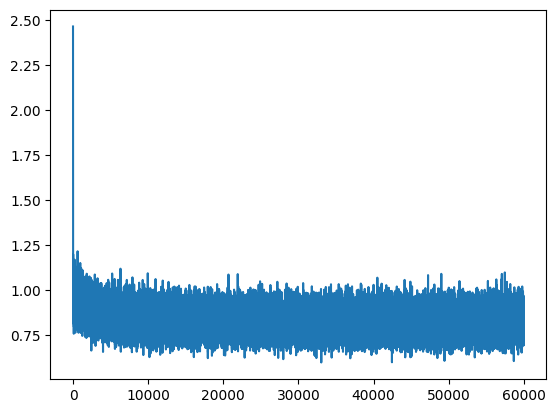

In [5]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# Generate samples

In [6]:
n_samples = 30000


# x = X_train_tensor # torch.randn(n_samples, 2)
# n_samples = x.shape[0]

# random uniform between -2.5 and 2.5 (a box)
box_size = 8
x = torch.rand(n_samples, 2) * box_size - box_size / 2


u = 0.05
sigma_mid = ((sigma_min_train ** (1.0 / rho)) +
             u * ((sigma_max_train ** (1.0 / rho)) - (sigma_min_train ** (1.0 / rho)))) ** rho

sigma = torch.ones(n_samples, 1) * sigma_mid
x_in, sigma_in, _ = create_effective_input_out(x, sigma)
with torch.no_grad():
    s = model(x_in.to(device), sigma_in.to(device))

s = s.norm(dim=1)

x.shape, s.shape

(torch.Size([30000, 2]), torch.Size([30000]))

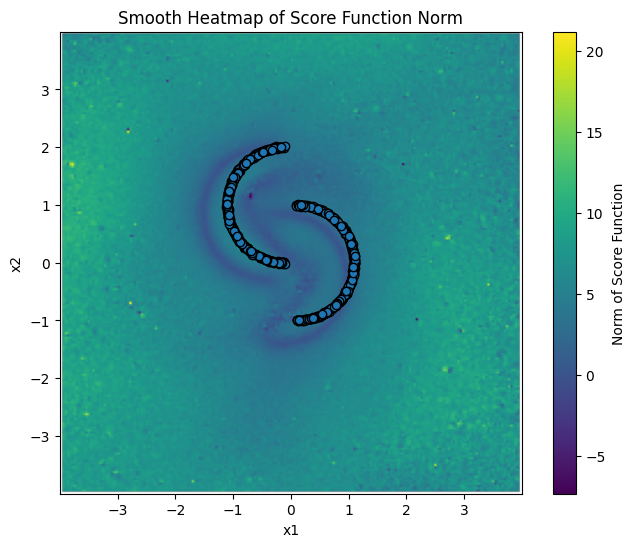

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Convert tensors to numpy arrays if needed
x_np = x.cpu().numpy() if hasattr(x, 'numpy') else x
s_np = s.cpu().numpy() if hasattr(s, 'numpy') else s

# Create a grid over the domain of your data
xi = np.linspace(x_np[:, 0].min(), x_np[:, 0].max(), 200)
yi = np.linspace(x_np[:, 1].min(), x_np[:, 1].max(), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the norm values onto the grid
zi = griddata((x_np[:, 0], x_np[:, 1]), s_np, (xi, yi), method='cubic')

plt.figure(figsize=(8, 6))
plt.imshow(zi, extent=(x_np[:, 0].min(), x_np[:, 0].max(), 
                       x_np[:, 1].min(), x_np[:, 1].max()),
           origin='lower', cmap='viridis')
plt.colorbar(label='Norm of Score Function')

plt.scatter(X_train[:, 0], X_train[:, 1], edgecolor='k')

plt.title('Smooth Heatmap of Score Function Norm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


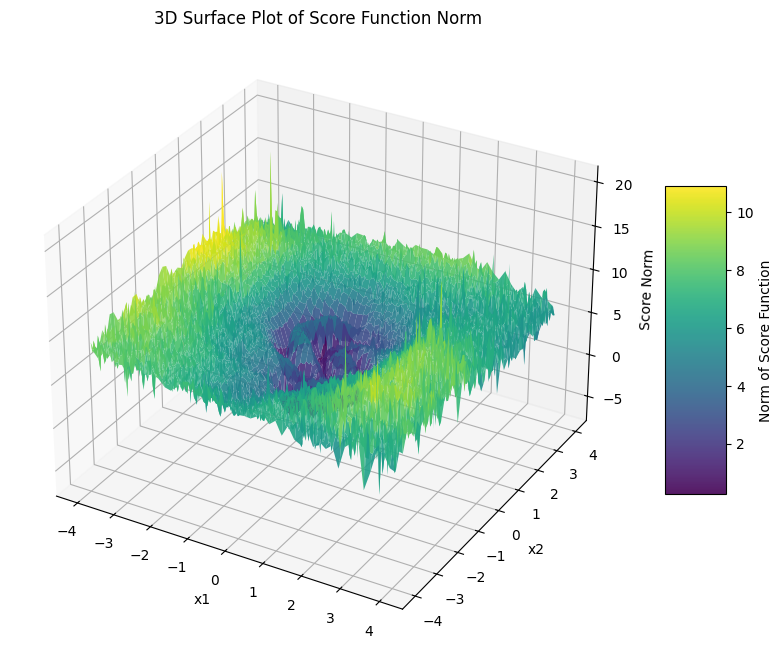

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
from scipy.interpolate import griddata

# 1. Prepare your data
x_np = x.cpu().numpy() if hasattr(x, 'numpy') else x
s_np = s.cpu().numpy() if hasattr(s, 'numpy') else s

# Create a grid over the domain of your data
xi = np.linspace(x_np[:, 0].min(), x_np[:, 0].max(), 200)
yi = np.linspace(x_np[:, 1].min(), x_np[:, 1].max(), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the values (norm of score) onto the grid
zi = griddata((x_np[:, 0], x_np[:, 1]), s_np, (xi, yi), method='cubic')

# 2. Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# plot_surface requires xi, yi, zi to be 2D arrays
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.9)

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Norm of Score Function')

ax.set_title('3D Surface Plot of Score Function Norm')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Score Norm')
plt.show()


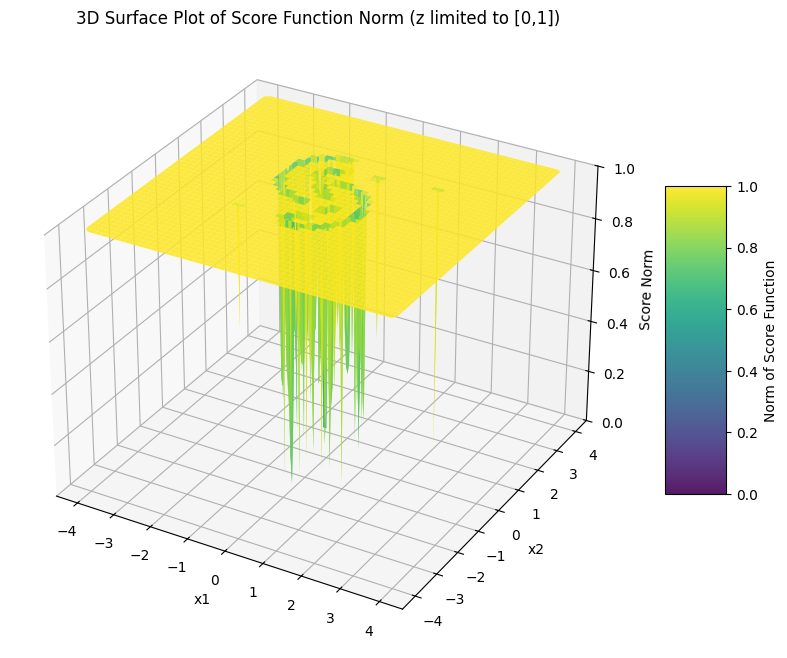

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
from scipy.interpolate import griddata

# 1. Prepare your data
x_np = x.cpu().numpy() if hasattr(x, 'numpy') else x
s_np = s.cpu().numpy() if hasattr(s, 'numpy') else s

# Create a grid over the domain of your data
xi = np.linspace(x_np[:, 0].min(), x_np[:, 0].max(), 200)
yi = np.linspace(x_np[:, 1].min(), x_np[:, 1].max(), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the values (norm of score) onto the grid
zi = griddata((x_np[:, 0], x_np[:, 1]), s_np, (xi, yi), method='cubic')

# Optionally, clip the data to ensure values remain between 0 and 1
zi = np.clip(zi, 0, 1)

# 2. Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Set vmin and vmax to normalize the colormap to the [0, 1] range.
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.9, vmin=0, vmax=1)

# Set z-axis limits to [0, 1]
ax.set_zlim(0, 1.0)

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Norm of Score Function')

ax.set_title('3D Surface Plot of Score Function Norm (z limited to [0,1])')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Score Norm')

plt.show()


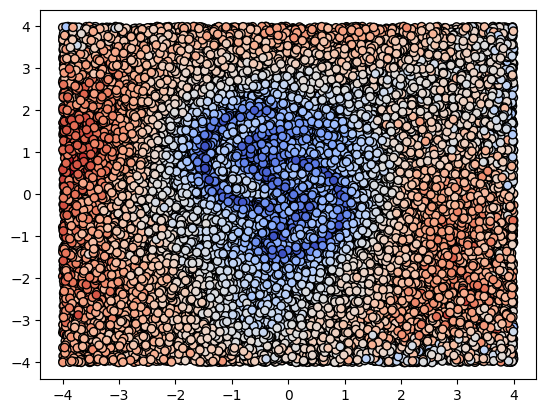

In [10]:
plt.scatter(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), c=s.cpu().numpy(), cmap=plt.cm.coolwarm, edgecolor='k')

# plot

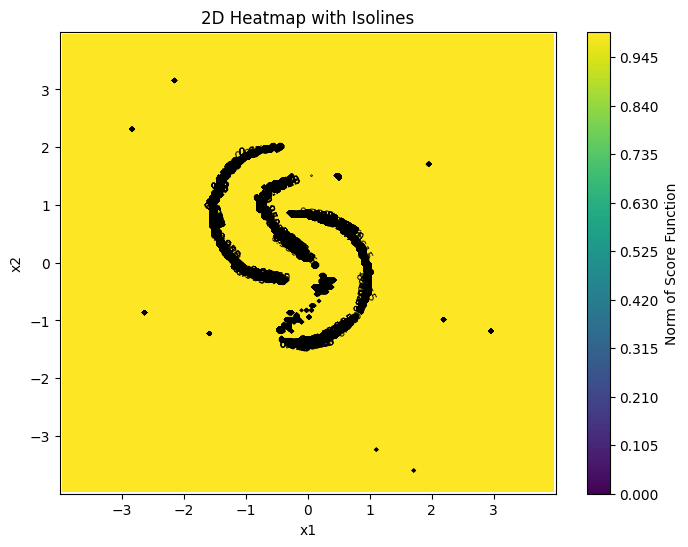

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Create filled contours for a smooth heatmap
contour_filled = plt.contourf(xi, yi, zi, levels=200, cmap='viridis')

# Overlay contour lines (isolines) on top
contour_lines = plt.contour(xi, yi, zi, levels=200, colors='black', linewidths=0.5)

# Optionally, add labels to the contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)

plt.colorbar(contour_filled, label='Norm of Score Function')
plt.title('2D Heatmap with Isolines')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
